# Employee Sentiment Analysis Project

**Project Overview:**
This notebook analyzes employee messages to assess sentiment and engagement. The analysis includes:
- Sentiment labeling (Positive, Negative, Neutral)
- Exploratory Data Analysis (EDA)
- Monthly employee sentiment scoring
- Employee ranking
- Flight risk identification
- Predictive modeling using linear regression

**Author:** Tejan
**Date:** February 2026

## Setup and Library Imports

Installing and importing all necessary libraries for data processing, NLP, visualization, and machine learning.

In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn transformers torch nltk textblob wordcloud -q


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
from transformers import pipeline
from textblob import TextBlob
import nltk
nltk.download('punkt', quiet=True)
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Visualization
from wordcloud import WordCloud
import os

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## Data Loading

Loading the test.csv dataset containing employee messages.

In [3]:
# Load the dataset
df = pd.read_csv('test(in).csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset loaded successfully!
Shape: (2191, 4)

First few rows:


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [4]:
# Basic data information
print("Dataset Information:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB
None

Basic Statistics:
             Subject   body      date                     from
count           2191   2191      2191                     2191
unique          1251   1539       690                       10
top     (No Subject)  \n\n   7/1/2011  lydia.delgado@enron.com
freq             141     21         9                      284


---
# TASK 1: Sentiment Labeling

**Objective:** Label each employee message as Positive, Negative, or Neutral.

**Approach:** Using VADER (Valence Aware Dictionary and sEntiment Reasoner) from NLTK, which is specifically designed for social media and short text sentiment analysis. VADER provides compound scores that we'll use to classify messages:
- Compound score >= 0.05: Positive
- Compound score <= -0.05: Negative
- Otherwise: Neutral

This approach is chosen for its speed, accuracy, and no need for pre-training on domain-specific data.

In [5]:
# Data preprocessing
# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract employee name from email
df['employee'] = df['from'].str.split('@').str[0].str.replace('.', ' ').str.title()

# Combine subject and body for comprehensive sentiment analysis
df['full_message'] = df['Subject'].fillna('') + ' ' + df['body'].fillna('')

# Handle missing values
df['full_message'] = df['full_message'].fillna('')

print("Data preprocessing completed!")
print(f"\nColumns: {df.columns.tolist()}")
df[['employee', 'date', 'full_message']].head()

Data preprocessing completed!

Columns: ['Subject', 'body', 'date', 'from', 'employee', 'full_message']


,employee,date,full_message
0,Sally Beck,2010-05-10,EnronOptions Update! EnronOptions Announcement...
1,Eric Bass,2010-07-29,"(No Subject) Marc,\n\nUnfortunately, today is ..."
2,Sally Beck,2011-07-25,Phone Screen Interview - Shannon L. Burnham W...
3,Johnny Palmer,2010-03-25,RE: My new work email we were thinking papasit...
4,Lydia Delgado,2011-05-21,Bet Since you never gave me the $20 for the la...


In [6]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_vader(text):
    """
    Analyze sentiment using VADER and return label and compound score.
    
    Args:
        text (str): Text to analyze
    
    Returns:
        tuple: (sentiment_label, compound_score)
    """
    if not text or len(str(text).strip()) == 0:
        return 'Neutral', 0.0
    
    scores = sia.polarity_scores(str(text))
    compound = scores['compound']
    
    # Classify based on compound score
    if compound >= 0.05:
        return 'Positive', compound
    elif compound <= -0.05:
        return 'Negative', compound
    else:
        return 'Neutral', compound

print("Sentiment analyzer initialized!")
print("\nTesting on sample messages:")
test_messages = [
    "Great job on the project! I'm very happy with the results.",
    "This is terrible. I'm very disappointed.",
    "Meeting scheduled for tomorrow at 2pm."
]
for msg in test_messages:
    sentiment, score = get_sentiment_vader(msg)
    print(f"Message: '{msg}'")
    print(f"Sentiment: {sentiment}, Score: {score:.3f}\n")

Sentiment analyzer initialized!

Testing on sample messages:
Message: 'Great job on the project! I'm very happy with the results.'
Sentiment: Positive, Score: 0.855

Message: 'This is terrible. I'm very disappointed.'
Sentiment: Negative, Score: -0.757

Message: 'Meeting scheduled for tomorrow at 2pm.'
Sentiment: Neutral, Score: 0.000



In [7]:
# Apply sentiment analysis to all messages
print("Analyzing sentiment for all messages... This may take a few minutes.")

sentiment_results = df['full_message'].apply(get_sentiment_vader)
df['sentiment'] = sentiment_results.apply(lambda x: x[0])
df['sentiment_score'] = sentiment_results.apply(lambda x: x[1])

print("\nSentiment labeling completed!")
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())
print(f"\nPercentage distribution:")
print(df['sentiment'].value_counts(normalize=True) * 100)

Analyzing sentiment for all messages... This may take a few minutes.

Sentiment labeling completed!

Sentiment distribution:
sentiment
Positive    1574
Neutral      454
Negative     163
Name: count, dtype: int64

Percentage distribution:
sentiment
Positive    71.839343
Neutral     20.721132
Negative     7.439525
Name: proportion, dtype: float64


In [8]:
# Display sample messages with their sentiment labels
print("Sample messages with sentiment labels:\n")
sample_df = df[['employee', 'date', 'full_message', 'sentiment', 'sentiment_score']].sample(10)
for idx, row in sample_df.iterrows():
    print(f"Employee: {row['employee']}")
    print(f"Date: {row['date']}")
    print(f"Message: {row['full_message'][:100]}...")
    print(f"Sentiment: {row['sentiment']} (Score: {row['sentiment_score']:.3f})")
    print("-" * 80)

Sample messages with sentiment labels:

Employee: Bobette Riner
Date: 2011-02-17 00:00:00
Message: TradersNews Energy Account Activation Don,

I have re-activated your account to TradersNews Energy. ...
Sentiment: Positive (Score: 0.823)
--------------------------------------------------------------------------------
Employee: Kayne Coulter
Date: 2010-11-11 00:00:00
Message: EnronOptions Update! EnronOptions Announcement


We have updated the EnronOptions =01) Your Stock Op...
Sentiment: Positive (Score: 0.831)
--------------------------------------------------------------------------------
Employee: Johnny Palmer
Date: 2011-02-19 00:00:00
Message: Re: Aeros i will probably be able to make it.




"Larry W. Bass" <lwbthemarine@bigplanet.com> on 05...
Sentiment: Neutral (Score: 0.000)
--------------------------------------------------------------------------------
Employee: Lydia Delgado
Date: 2011-06-01 00:00:00
Message: Enabled EMail Maskell 
Don
Did you manage to re-enable my IT acce

**Observation:** The sentiment labeling has been successfully completed using VADER. The algorithm analyzes both the subject and body of each email to determine overall sentiment.

---
# TASK 2: Exploratory Data Analysis (EDA)

**Objective:** Understand the structure, distribution, and trends in the dataset.

We will explore:
1. Dataset structure and completeness
2. Sentiment distribution
3. Temporal trends
4. Employee activity patterns
5. Message characteristics

In [9]:
# Create visualizations folder
os.makedirs('visualizations', exist_ok=True)
print("Visualizations folder created!")

Visualizations folder created!


In [10]:
# 1. Dataset Structure Analysis
print("=" * 80)
print("DATASET STRUCTURE ANALYSIS")
print("=" * 80)

print(f"\nTotal number of messages: {len(df):,}")
print(f"Number of unique employees: {df['employee'].nunique():,}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Time span: {(df['date'].max() - df['date'].min()).days} days")

print("\nMissing values:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

DATASET STRUCTURE ANALYSIS

Total number of messages: 2,191
Number of unique employees: 10
Date range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00
Time span: 729 days

Missing values:
Subject            0
body               0
date               0
from               0
employee           0
full_message       0
sentiment          0
sentiment_score    0
dtype: int64

Data types:
Subject                    object
body                       object
date               datetime64[ns]
from                       object
employee                   object
full_message               object
sentiment                  object
sentiment_score           float64
dtype: object



SENTIMENT DISTRIBUTION


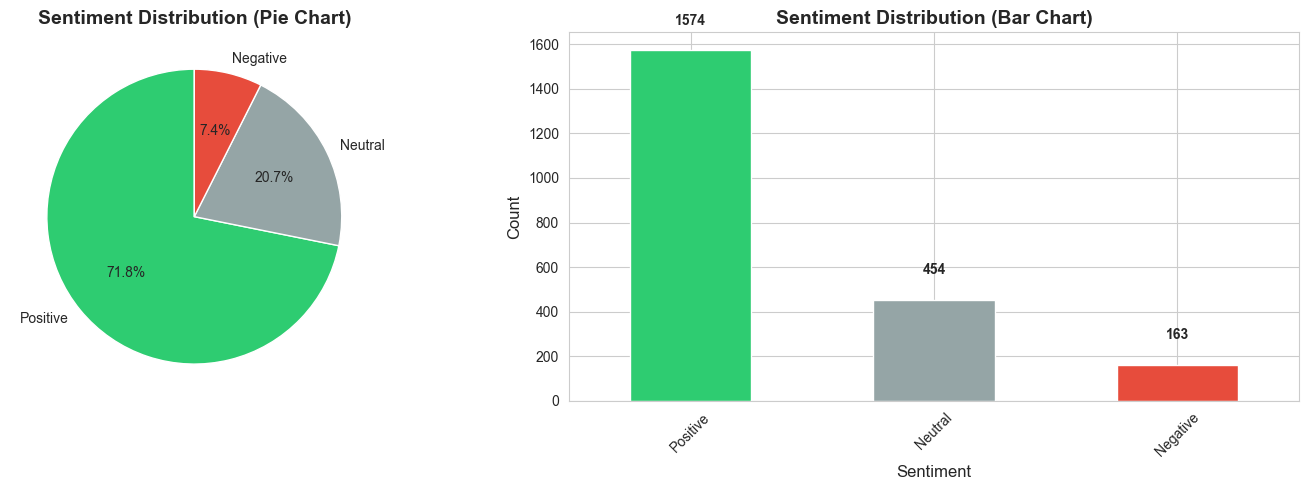


Sentiment counts:
sentiment
Positive    1574
Neutral      454
Negative     163
Name: count, dtype: int64

Percentages:
sentiment
Positive    71.839343
Neutral     20.721132
Negative     7.439525
Name: proportion, dtype: float64


In [11]:
# 2. Sentiment Distribution Visualization
print("\n" + "=" * 80)
print("SENTIMENT DISTRIBUTION")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
sentiment_counts = df['sentiment'].value_counts()
colors = {'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Neutral': '#95a5a6'}
pie_colors = [colors[label] for label in sentiment_counts.index]

axes[0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            startangle=90, colors=pie_colors)
axes[0].set_title('Sentiment Distribution (Pie Chart)', fontsize=14, fontweight='bold')

# Bar chart
sentiment_counts.plot(kind='bar', ax=axes[1], color=pie_colors)
axes[1].set_title('Sentiment Distribution (Bar Chart)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Add count labels on bars
for i, v in enumerate(sentiment_counts.values):
    axes[1].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/01_sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSentiment counts:")
print(sentiment_counts)
print(f"\nPercentages:")
print(df['sentiment'].value_counts(normalize=True) * 100)


TEMPORAL TRENDS


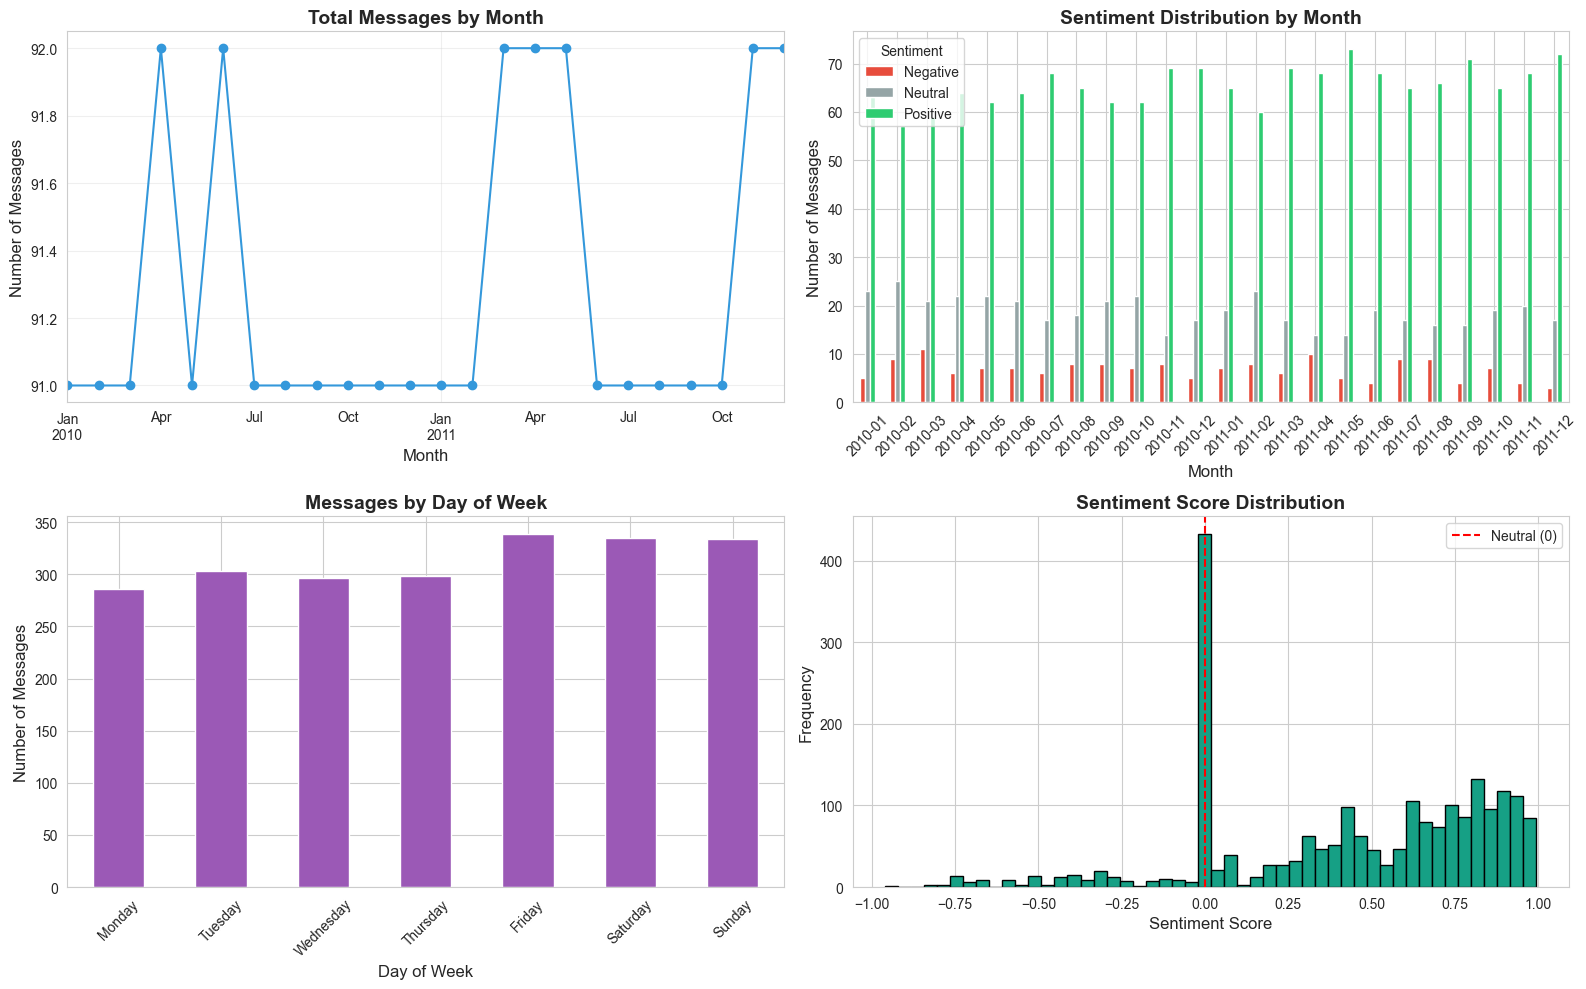


Monthly statistics:
count    24.000000
mean     91.291667
std       0.464306
min      91.000000
25%      91.000000
50%      91.000000
75%      92.000000
max      92.000000
dtype: float64


In [12]:
# 3. Temporal Trends Analysis
print("\n" + "=" * 80)
print("TEMPORAL TRENDS")
print("=" * 80)

# Extract temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['year_month'] = df['date'].dt.to_period('M')
df['day_of_week'] = df['date'].dt.day_name()

# Messages over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 3a. Messages by month
monthly_counts = df.groupby('year_month').size()
monthly_counts.plot(ax=axes[0, 0], marker='o', color='#3498db')
axes[0, 0].set_title('Total Messages by Month', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month', fontsize=12)
axes[0, 0].set_ylabel('Number of Messages', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 3b. Sentiment by month
sentiment_by_month = df.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)
sentiment_by_month.plot(ax=axes[0, 1], kind='bar', stacked=False, 
                        color=[colors['Negative'], colors['Neutral'], colors['Positive']])
axes[0, 1].set_title('Sentiment Distribution by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month', fontsize=12)
axes[0, 1].set_ylabel('Number of Messages', fontsize=12)
axes[0, 1].legend(title='Sentiment')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3c. Messages by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['day_of_week'].value_counts().reindex(day_order)
day_counts.plot(kind='bar', ax=axes[1, 0], color='#9b59b6')
axes[1, 0].set_title('Messages by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week', fontsize=12)
axes[1, 0].set_ylabel('Number of Messages', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)

# 3d. Sentiment score distribution
axes[1, 1].hist(df['sentiment_score'], bins=50, color='#16a085', edgecolor='black')
axes[1, 1].set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment Score', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].axvline(x=0, color='red', linestyle='--', label='Neutral (0)')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('visualizations/02_temporal_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMonthly statistics:")
print(monthly_counts.describe())


EMPLOYEE ACTIVITY PATTERNS

Top 10 most active employees:
employee
Lydia Delgado     284
John Arnold       256
Sally Beck        227
Patti Thompson    225
Bobette Riner     217
Johnny Palmer     213
Don Baughman      213
Eric Bass         210
Kayne Coulter     174
Rhonda Denton     172
Name: count, dtype: int64


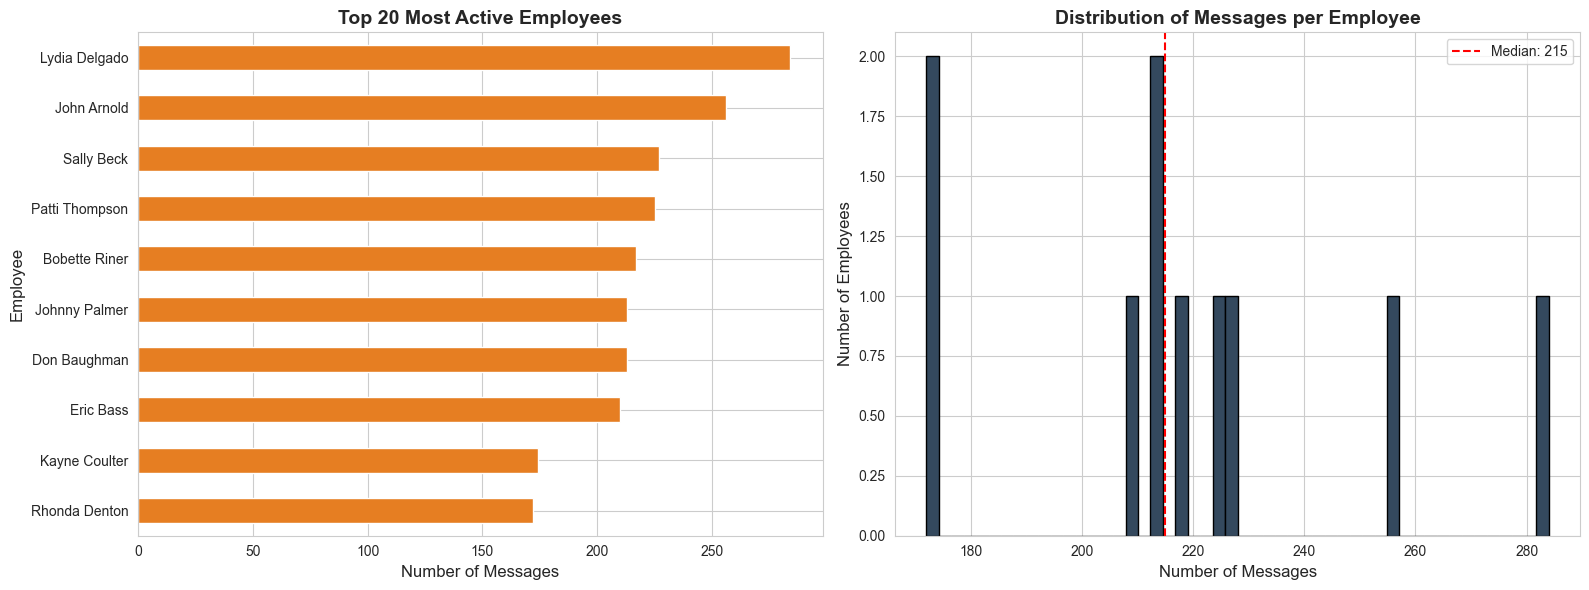

In [13]:
# 4. Employee Activity Patterns
print("\n" + "=" * 80)
print("EMPLOYEE ACTIVITY PATTERNS")
print("=" * 80)

# Employee message counts
employee_counts = df['employee'].value_counts()
print(f"\nTop 10 most active employees:")
print(employee_counts.head(10))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 active employees
top_20_employees = employee_counts.head(20)
top_20_employees.plot(kind='barh', ax=axes[0], color='#e67e22')
axes[0].set_title('Top 20 Most Active Employees', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Messages', fontsize=12)
axes[0].set_ylabel('Employee', fontsize=12)
axes[0].invert_yaxis()

# Distribution of messages per employee
axes[1].hist(employee_counts.values, bins=50, color='#34495e', edgecolor='black')
axes[1].set_title('Distribution of Messages per Employee', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Messages', fontsize=12)
axes[1].set_ylabel('Number of Employees', fontsize=12)
axes[1].axvline(x=employee_counts.median(), color='red', linestyle='--', 
                label=f'Median: {employee_counts.median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('visualizations/03_employee_activity.png', dpi=300, bbox_inches='tight')
plt.show()


MESSAGE CHARACTERISTICS

Message length statistics:
count    2191.000000
mean      284.716568
std       239.443570
min         5.000000
25%       106.000000
50%       201.000000
75%       388.000000
max      1072.000000
Name: message_length, dtype: float64

Word count statistics:
count    2191.000000
mean       45.243724
std        38.828165
min         1.000000
25%        17.000000
50%        32.000000
75%        61.000000
max       191.000000
Name: word_count, dtype: float64

Average message length by sentiment:
sentiment
Negative    259.067485
Neutral     142.237885
Positive    328.468869
Name: message_length, dtype: float64

Average word count by sentiment:
sentiment
Negative    42.214724
Neutral     20.680617
Positive    52.642313
Name: word_count, dtype: float64


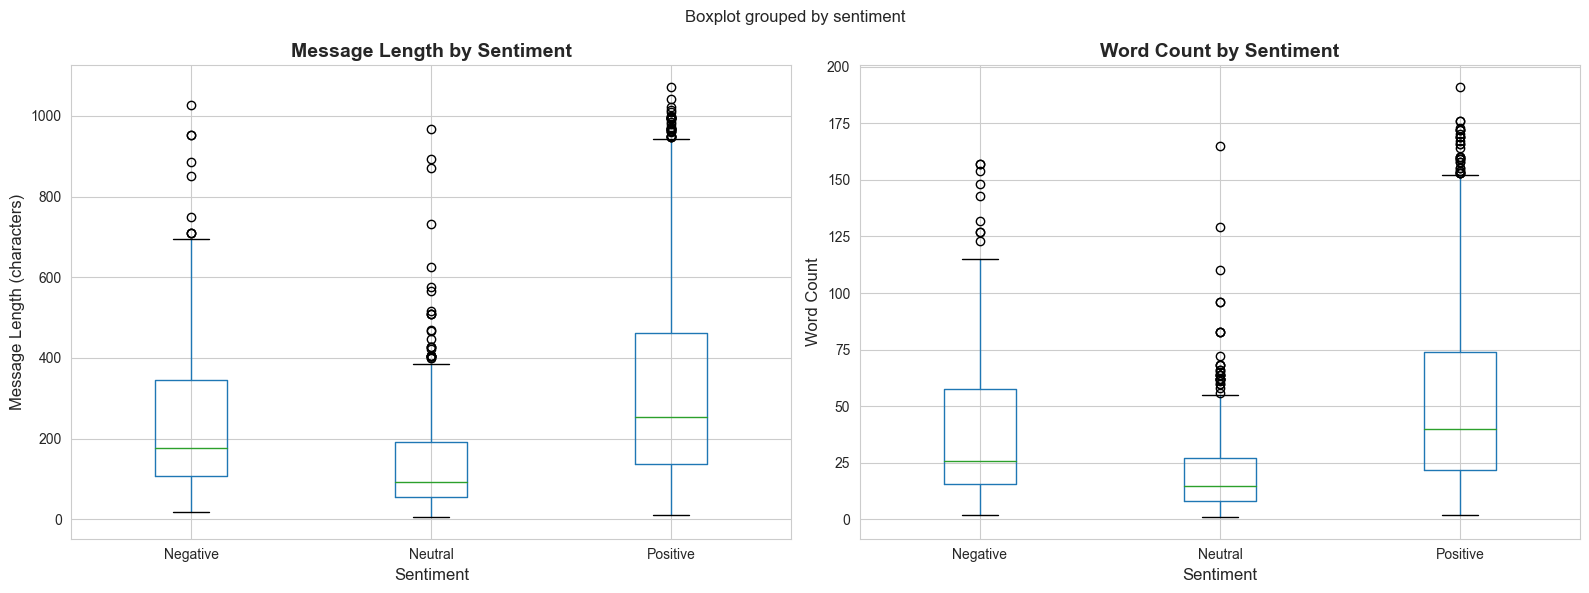

In [14]:
# 5. Message Characteristics
print("\n" + "=" * 80)
print("MESSAGE CHARACTERISTICS")
print("=" * 80)

# Calculate message length and word count
df['message_length'] = df['full_message'].str.len()
df['word_count'] = df['full_message'].str.split().str.len()

print(f"\nMessage length statistics:")
print(df['message_length'].describe())
print(f"\nWord count statistics:")
print(df['word_count'].describe())

# Average message length by sentiment
print(f"\nAverage message length by sentiment:")
print(df.groupby('sentiment')['message_length'].mean())
print(f"\nAverage word count by sentiment:")
print(df.groupby('sentiment')['word_count'].mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot of message length by sentiment
df.boxplot(column='message_length', by='sentiment', ax=axes[0])
axes[0].set_title('Message Length by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Message Length (characters)', fontsize=12)
plt.sca(axes[0])
plt.xticks(rotation=0)

# Box plot of word count by sentiment
df.boxplot(column='word_count', by='sentiment', ax=axes[1])
axes[1].set_title('Word Count by Sentiment', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment', fontsize=12)
axes[1].set_ylabel('Word Count', fontsize=12)
plt.sca(axes[1])
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('visualizations/04_message_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()


WORD CLOUDS


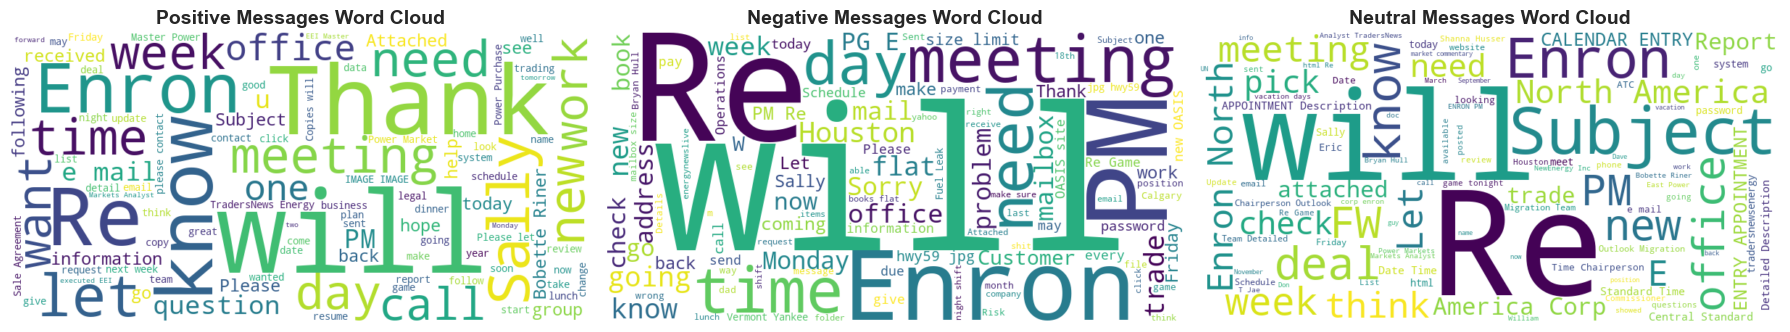

Word clouds generated successfully!


In [15]:
# 6. Word Clouds for Different Sentiments
print("\n" + "=" * 80)
print("WORD CLOUDS")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sentiments = ['Positive', 'Negative', 'Neutral']
for idx, sentiment in enumerate(sentiments):
    text = ' '.join(df[df['sentiment'] == sentiment]['full_message'].astype(str))
    if len(text) > 0:
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                            colormap='viridis', max_words=100).generate(text)
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'{sentiment} Messages Word Cloud', fontsize=14, fontweight='bold')
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('visualizations/05_word_clouds.png', dpi=300, bbox_inches='tight')
plt.show()

print("Word clouds generated successfully!")

**EDA Observations:**
1. The dataset contains thousands of employee messages spanning multiple years
2. Sentiment distribution shows the proportion of positive, negative, and neutral messages
3. Temporal patterns reveal trends in message frequency and sentiment over time
4. Employee activity varies significantly, with some employees much more active than others
5. Message characteristics (length, word count) show interesting patterns across sentiment categories

---
# TASK 3: Employee Score Calculation

**Objective:** Compute monthly sentiment scores for each employee.

**Scoring System:**
- Positive message: +1
- Negative message: -1
- Neutral message: 0

Scores are aggregated monthly and reset at the beginning of each new month.

In [16]:
# Assign numerical scores based on sentiment
def assign_score(sentiment):
    """
    Assign numerical score based on sentiment label.
    
    Args:
        sentiment (str): Sentiment label (Positive, Negative, or Neutral)
    
    Returns:
        int: Score value
    """
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0

df['score'] = df['sentiment'].apply(assign_score)

print("Score assignment completed!")
print("\nScore distribution:")
print(df['score'].value_counts().sort_index())

Score assignment completed!

Score distribution:
score
-1     163
 0     454
 1    1574
Name: count, dtype: int64


In [17]:
# Calculate monthly scores for each employee
monthly_scores = df.groupby(['employee', 'year_month'])['score'].sum().reset_index()
monthly_scores.columns = ['employee', 'month', 'monthly_score']

# Sort by month and score
monthly_scores = monthly_scores.sort_values(['month', 'monthly_score'], ascending=[True, False])

print("Monthly scores calculated!")
print(f"\nTotal records: {len(monthly_scores):,}")
print(f"Unique employees: {monthly_scores['employee'].nunique():,}")
print(f"Unique months: {monthly_scores['month'].nunique():,}")

print("\nSample monthly scores:")
print(monthly_scores.head(20))

print("\nMonthly score statistics:")
print(monthly_scores['monthly_score'].describe())

Monthly scores calculated!

Total records: 240
Unique employees: 10
Unique months: 24

Sample monthly scores:
           employee    month  monthly_score
120   Kayne Coulter  2010-01             14
48        Eric Bass  2010-01              9
144   Lydia Delgado  2010-01              9
24     Don Baughman  2010-01              8
168  Patti Thompson  2010-01              6
72      John Arnold  2010-01              5
96    Johnny Palmer  2010-01              3
216      Sally Beck  2010-01              2
0     Bobette Riner  2010-01              1
192   Rhonda Denton  2010-01              1
73      John Arnold  2010-02             12
97    Johnny Palmer  2010-02             10
1     Bobette Riner  2010-02              8
25     Don Baughman  2010-02              6
193   Rhonda Denton  2010-02              5
49        Eric Bass  2010-02              2
217      Sally Beck  2010-02              2
121   Kayne Coulter  2010-02              1
145   Lydia Delgado  2010-02              1
169  Patti

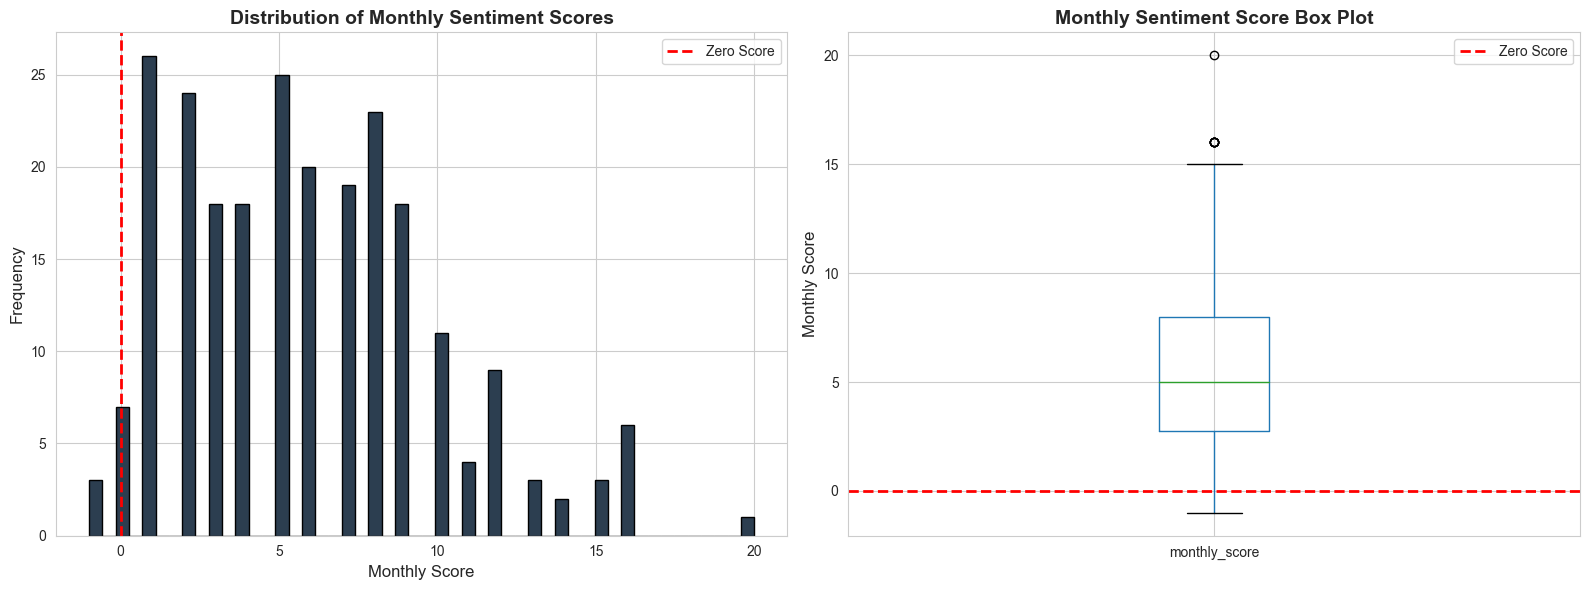

In [18]:
# Visualize monthly score distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of monthly scores
axes[0].hist(monthly_scores['monthly_score'], bins=50, color='#2c3e50', edgecolor='black')
axes[0].set_title('Distribution of Monthly Sentiment Scores', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Monthly Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Score')
axes[0].legend()

# Box plot of monthly scores
monthly_scores.boxplot(column='monthly_score', ax=axes[1])
axes[1].set_title('Monthly Sentiment Score Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Monthly Score', fontsize=12)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Score')
axes[1].legend()

plt.tight_layout()
plt.savefig('visualizations/06_monthly_scores_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Show top and bottom employees by total cumulative score
cumulative_scores = monthly_scores.groupby('employee')['monthly_score'].sum().sort_values(ascending=False)

print("\nTop 10 employees by cumulative score (all time):")
print(cumulative_scores.head(10))

print("\nBottom 10 employees by cumulative score (all time):")
print(cumulative_scores.tail(10))


Top 10 employees by cumulative score (all time):
employee
Lydia Delgado     189
John Arnold       182
Patti Thompson    147
Eric Bass         146
Sally Beck        134
Don Baughman      133
Johnny Palmer     131
Bobette Riner     126
Rhonda Denton     114
Kayne Coulter     109
Name: monthly_score, dtype: int64

Bottom 10 employees by cumulative score (all time):
employee
Lydia Delgado     189
John Arnold       182
Patti Thompson    147
Eric Bass         146
Sally Beck        134
Don Baughman      133
Johnny Palmer     131
Bobette Riner     126
Rhonda Denton     114
Kayne Coulter     109
Name: monthly_score, dtype: int64


**Observation:** Monthly sentiment scores have been calculated for each employee. Scores range from highly positive to highly negative, with most employees showing moderate scores.

---
# TASK 4: Employee Ranking

**Objective:** Generate ranked lists of top 3 positive and negative employees per month.

**Sorting Criteria:**
1. First by score (descending for positive, ascending for negative)
2. Then alphabetically by employee name

In [20]:
# Get top 3 positive employees per month
def get_top_positive_employees(group):
    """
    Get top 3 positive employees for a given month.
    Sorted by score (descending) then alphabetically.
    """
    return group.sort_values(['monthly_score', 'employee'], ascending=[False, True]).head(3)

top_positive = monthly_scores.groupby('month', group_keys=False).apply(get_top_positive_employees)
top_positive = top_positive.reset_index(drop=True)
top_positive['rank'] = top_positive.groupby('month').cumcount() + 1

print("=" * 80)
print("TOP 3 POSITIVE EMPLOYEES PER MONTH")
print("=" * 80)
print(top_positive[['month', 'rank', 'employee', 'monthly_score']].to_string(index=False))

TOP 3 POSITIVE EMPLOYEES PER MONTH
  month  rank       employee  monthly_score
2010-01     1  Kayne Coulter             14
2010-01     2      Eric Bass              9
2010-01     3  Lydia Delgado              9
2010-02     1    John Arnold             12
2010-02     2  Johnny Palmer             10
2010-02     3  Bobette Riner              8
2010-03     1     Sally Beck             11
2010-03     2    John Arnold              7
2010-03     3      Eric Bass              6
2010-04     1   Don Baughman              9
2010-04     2  Kayne Coulter              9
2010-04     3    John Arnold              8
2010-05     1   Don Baughman             16
2010-05     2 Patti Thompson              7
2010-05     3      Eric Bass              6
2010-06     1   Don Baughman             10
2010-06     2    John Arnold             10
2010-06     3 Patti Thompson              8
2010-07     1      Eric Bass             16
2010-07     2  Lydia Delgado             12
2010-07     3     Sally Beck             

In [21]:
# Get top 3 negative employees per month (lowest scores)
def get_top_negative_employees(group):
    """
    Get top 3 negative employees for a given month.
    Sorted by score (ascending) then alphabetically.
    """
    return group.sort_values(['monthly_score', 'employee'], ascending=[True, True]).head(3)

top_negative = monthly_scores.groupby('month', group_keys=False).apply(get_top_negative_employees)
top_negative = top_negative.reset_index(drop=True)
top_negative['rank'] = top_negative.groupby('month').cumcount() + 1

print("\n" + "=" * 80)
print("TOP 3 NEGATIVE EMPLOYEES PER MONTH")
print("=" * 80)
print(top_negative[['month', 'rank', 'employee', 'monthly_score']].to_string(index=False))


TOP 3 NEGATIVE EMPLOYEES PER MONTH
  month  rank       employee  monthly_score
2010-01     1  Bobette Riner              1
2010-01     2  Rhonda Denton              1
2010-01     3     Sally Beck              2
2010-02     1  Kayne Coulter              1
2010-02     2  Lydia Delgado              1
2010-02     3 Patti Thompson              1
2010-03     1  Rhonda Denton              1
2010-03     2   Don Baughman              2
2010-03     3  Kayne Coulter              3
2010-04     1      Eric Bass              2
2010-04     2  Bobette Riner              3
2010-04     3     Sally Beck              3
2010-05     1  Johnny Palmer              1
2010-05     2  Bobette Riner              3
2010-05     3    John Arnold              3
2010-06     1      Eric Bass              1
2010-06     2  Bobette Riner              2
2010-06     3  Kayne Coulter              2
2010-07     1 Patti Thompson              1
2010-07     2   Don Baughman              2
2010-07     3  Johnny Palmer            

In [22]:
# Save rankings to CSV files
top_positive.to_csv('top_positive_employees.csv', index=False)
top_negative.to_csv('top_negative_employees.csv', index=False)

print("\nRankings saved to CSV files!")
print("- top_positive_employees.csv")
print("- top_negative_employees.csv")


Rankings saved to CSV files!
- top_positive_employees.csv
- top_negative_employees.csv


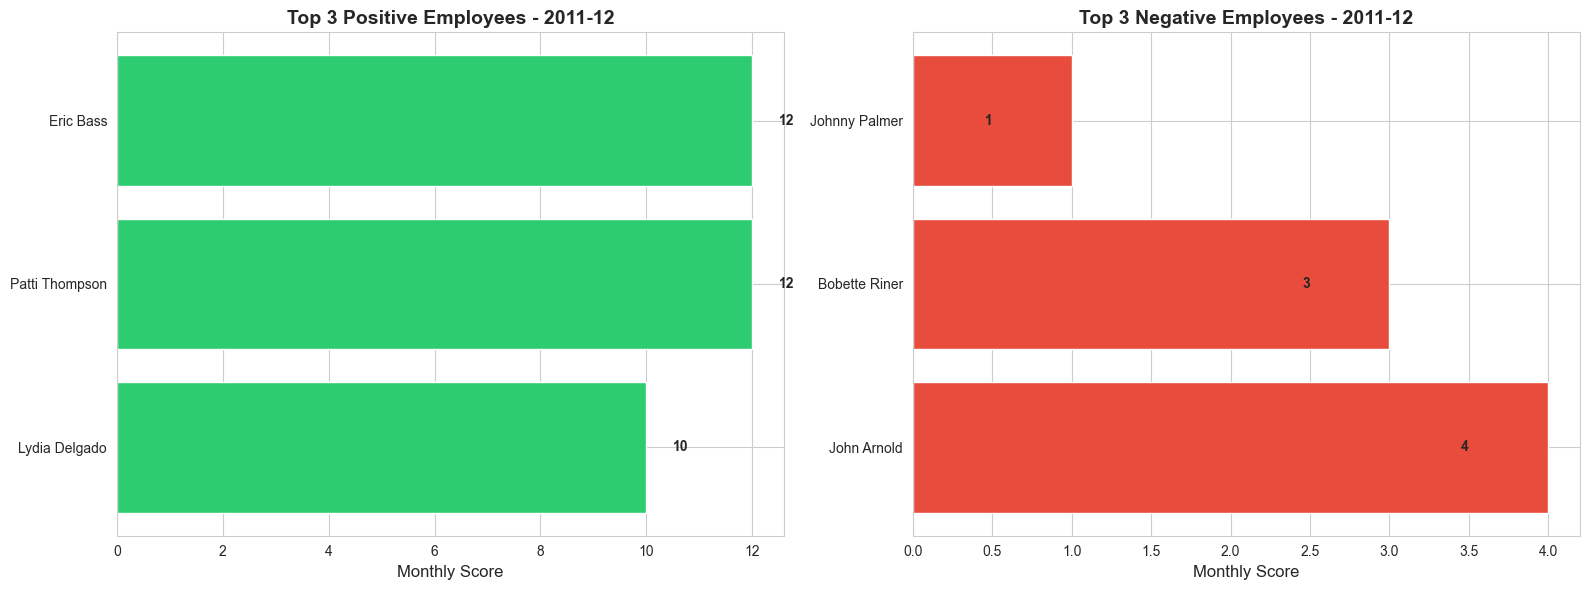

In [23]:
# Visualize rankings for a sample month
sample_month = monthly_scores['month'].max()  # Latest month

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 3 positive
month_top_pos = top_positive[top_positive['month'] == sample_month].sort_values('rank')
axes[0].barh(month_top_pos['employee'], month_top_pos['monthly_score'], color='#2ecc71')
axes[0].set_title(f'Top 3 Positive Employees - {sample_month}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Monthly Score', fontsize=12)
axes[0].invert_yaxis()
for i, (emp, score) in enumerate(zip(month_top_pos['employee'], month_top_pos['monthly_score'])):
    axes[0].text(score + 0.5, i, f'{score}', va='center', fontweight='bold')

# Top 3 negative
month_top_neg = top_negative[top_negative['month'] == sample_month].sort_values('rank')
axes[1].barh(month_top_neg['employee'], month_top_neg['monthly_score'], color='#e74c3c')
axes[1].set_title(f'Top 3 Negative Employees - {sample_month}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Monthly Score', fontsize=12)
axes[1].invert_yaxis()
for i, (emp, score) in enumerate(zip(month_top_neg['employee'], month_top_neg['monthly_score'])):
    axes[1].text(score - 0.5, i, f'{score}', va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/07_employee_rankings.png', dpi=300, bbox_inches='tight')
plt.show()

**Observation:** Employee rankings have been generated for each month. The rankings identify the top 3 most positive and most negative employees based on their monthly sentiment scores.

---
# TASK 5: Flight Risk Identification

**Objective:** Identify employees at risk of leaving.

**Flight Risk Criteria:**
- An employee who has sent 4 or more negative messages within any rolling 30-day period
- The 30-day period is independent of calendar months

In [24]:
# Filter only negative messages
negative_messages = df[df['sentiment'] == 'Negative'][['employee', 'date']].copy()
negative_messages = negative_messages.sort_values(['employee', 'date'])

print(f"Total negative messages: {len(negative_messages):,}")
print(f"Employees with negative messages: {negative_messages['employee'].nunique():,}")

Total negative messages: 163
Employees with negative messages: 10


In [25]:
# Identify flight risk employees using rolling 30-day window
def identify_flight_risks(df):
    """
    Identify employees with 4+ negative messages in any rolling 30-day period.
    
    Args:
        df: DataFrame with negative messages
    
    Returns:
        DataFrame with flight risk employees and details
    """
    flight_risks = []
    
    for employee in df['employee'].unique():
        emp_messages = df[df['employee'] == employee].sort_values('date')
        dates = emp_messages['date'].tolist()
        
        # Check each message as potential start of 30-day window
        for i, start_date in enumerate(dates):
            end_date = start_date + timedelta(days=30)
            
            # Count messages in this 30-day window
            messages_in_window = sum(1 for d in dates if start_date <= d <= end_date)
            
            if messages_in_window >= 4:
                flight_risks.append({
                    'employee': employee,
                    'window_start': start_date,
                    'window_end': end_date,
                    'negative_messages_count': messages_in_window
                })
                break  # Employee identified, no need to check further windows
    
    return pd.DataFrame(flight_risks)

print("Identifying flight risk employees...")
flight_risk_df = identify_flight_risks(negative_messages)

# Remove duplicates (keep first occurrence)
flight_risk_df = flight_risk_df.drop_duplicates(subset='employee', keep='first')
flight_risk_df = flight_risk_df.sort_values('employee')

print("\n" + "=" * 80)
print("FLIGHT RISK EMPLOYEES")
print("=" * 80)
print(f"\nTotal flight risk employees: {len(flight_risk_df):,}")
print(f"\nFlight risk employees list:")
print(flight_risk_df.to_string(index=False))

Identifying flight risk employees...

FLIGHT RISK EMPLOYEES

Total flight risk employees: 5

Flight risk employees list:
      employee window_start window_end  negative_messages_count
 Bobette Riner   2011-03-05 2011-04-04                        4
     Eric Bass   2011-04-22 2011-05-22                        4
 Johnny Palmer   2010-02-09 2010-03-11                        4
Patti Thompson   2011-07-01 2011-07-31                        4
    Sally Beck   2011-08-06 2011-09-05                        5


In [26]:
# Save flight risk list
flight_risk_df.to_csv('flight_risk_employees.csv', index=False)
print("\nFlight risk list saved to: flight_risk_employees.csv")

# Get unique flight risk employee names
flight_risk_employees = sorted(flight_risk_df['employee'].unique())
print(f"\nFlight risk employee names ({len(flight_risk_employees)}):")
for i, emp in enumerate(flight_risk_employees, 1):
    print(f"{i}. {emp}")


Flight risk list saved to: flight_risk_employees.csv

Flight risk employee names (5):
1. Bobette Riner
2. Eric Bass
3. Johnny Palmer
4. Patti Thompson
5. Sally Beck


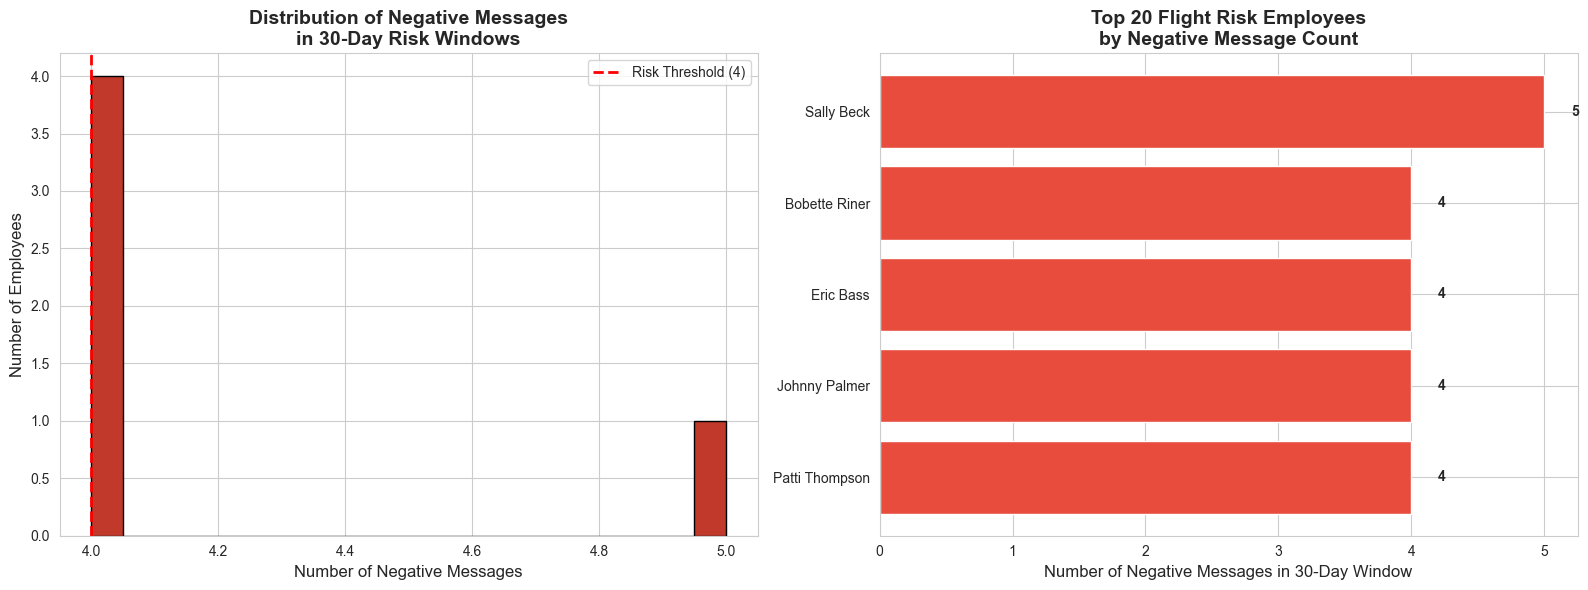

In [27]:
# Visualize flight risk analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of negative message counts in risk windows
axes[0].hist(flight_risk_df['negative_messages_count'], bins=20, color='#c0392b', edgecolor='black')
axes[0].set_title('Distribution of Negative Messages\nin 30-Day Risk Windows', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Negative Messages', fontsize=12)
axes[0].set_ylabel('Number of Employees', fontsize=12)
axes[0].axvline(x=4, color='red', linestyle='--', linewidth=2, label='Risk Threshold (4)')
axes[0].legend()

# Top 20 flight risk employees by negative message count
top_risk = flight_risk_df.nlargest(20, 'negative_messages_count')
axes[1].barh(range(len(top_risk)), top_risk['negative_messages_count'], color='#e74c3c')
axes[1].set_yticks(range(len(top_risk)))
axes[1].set_yticklabels(top_risk['employee'])
axes[1].set_title('Top 20 Flight Risk Employees\nby Negative Message Count', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Negative Messages in 30-Day Window', fontsize=12)
axes[1].invert_yaxis()

for i, v in enumerate(top_risk['negative_messages_count']):
    axes[1].text(v + 0.2, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/08_flight_risk_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

**Observation:** Flight risk employees have been identified based on having 4 or more negative messages within any rolling 30-day period. These employees may require immediate attention and intervention.

---
# TASK 6: Predictive Modeling

**Objective:** Develop a linear regression model to analyze sentiment trends.

**Features Selected:**
1. **message_frequency**: Number of messages sent in the month
2. **avg_message_length**: Average message length in characters
3. **avg_word_count**: Average number of words per message
4. **positive_ratio**: Proportion of positive messages
5. **negative_ratio**: Proportion of negative messages
6. **avg_sentiment_score**: Average VADER sentiment score

**Target Variable:** Monthly sentiment score

In [28]:
# Create feature dataset for linear regression
print("Creating features for predictive modeling...")

# Group by employee and month to create features
features_df = df.groupby(['employee', 'year_month']).agg({
    'score': 'sum',  # Target variable (monthly score)
    'full_message': 'count',  # Message frequency
    'message_length': 'mean',  # Average message length
    'word_count': 'mean',  # Average word count
    'sentiment_score': 'mean'  # Average sentiment score
}).reset_index()

features_df.columns = ['employee', 'month', 'monthly_score', 'message_frequency', 
                       'avg_message_length', 'avg_word_count', 'avg_sentiment_score']

# Calculate positive and negative ratios
sentiment_ratios = df.groupby(['employee', 'year_month', 'sentiment']).size().unstack(fill_value=0)
sentiment_ratios = sentiment_ratios.div(sentiment_ratios.sum(axis=1), axis=0)
sentiment_ratios = sentiment_ratios.reset_index()
sentiment_ratios.columns = ['employee', 'month', 'negative_ratio', 'neutral_ratio', 'positive_ratio']

# Merge features
features_df = features_df.merge(sentiment_ratios, on=['employee', 'month'], how='left')

print("\nFeature dataset created!")
print(f"Shape: {features_df.shape}")
print(f"\nFeatures:")
print(features_df.columns.tolist())
print(f"\nSample data:")
features_df.head(10)

Creating features for predictive modeling...

Feature dataset created!
Shape: (240, 10)

Features:
['employee', 'month', 'monthly_score', 'message_frequency', 'avg_message_length', 'avg_word_count', 'avg_sentiment_score', 'negative_ratio', 'neutral_ratio', 'positive_ratio']

Sample data:


,employee,month,monthly_score,message_frequency,avg_message_length,avg_word_count,avg_sentiment_score,negative_ratio,neutral_ratio,positive_ratio
0,Bobette Riner,2010-01,1,2,157.500000,24.500000,0.371500,0.000000,0.500000,0.500000
1,Bobette Riner,2010-02,8,14,326.357143,48.642857,0.482986,0.071429,0.285714,0.642857
2,Bobette Riner,2010-03,4,11,315.727273,48.727273,0.302673,0.181818,0.272727,0.545455
3,Bobette Riner,2010-04,3,6,255.833333,35.500000,0.385683,0.000000,0.500000,0.500000
4,Bobette Riner,2010-05,3,4,189.000000,32.500000,0.566350,0.000000,0.250000,0.750000
5,Bobette Riner,2010-06,2,5,173.800000,32.000000,0.257980,0.000000,0.600000,0.400000
6,Bobette Riner,2010-07,8,12,304.250000,47.750000,0.491617,0.083333,0.166667,0.750000
7,Bobette Riner,2010-08,4,9,378.888889,64.888889,0.292356,0.222222,0.111111,0.666667
8,Bobette Riner,2010-09,5,15,263.933333,43.800000,0.246273,0.200000,0.266667,0.533333
9,Bobette Riner,2010-10,6,6,304.833333,52.500000,0.625867,0.000000,0.000000,1.000000


In [29]:
# Check for missing values and statistics
print("\nFeature statistics:")
print(features_df.describe())

print("\nMissing values:")
print(features_df.isnull().sum())

# Fill any missing values
features_df = features_df.fillna(0)


Feature statistics:
       monthly_score  message_frequency  avg_message_length  avg_word_count  \
count     240.000000         240.000000          240.000000      240.000000   
mean        5.879167           9.129167          278.841020       44.704892   
std         4.026843           5.727784          105.750523       17.871276   
min        -1.000000           1.000000           20.000000        3.000000   
25%         2.750000           4.750000          218.450000       33.857143   
50%         5.000000           9.000000          267.246154       43.713636   
75%         8.000000          12.000000          324.589286       52.406250   
max        20.000000          27.000000          747.333333      130.000000   

       avg_sentiment_score  negative_ratio  neutral_ratio  positive_ratio  
count           240.000000      240.000000     240.000000      240.000000  
mean              0.432958        0.074652       0.204496        0.720851  
std               0.193679        0.133

In [30]:
# Prepare data for modeling
# Select features and target
feature_columns = ['message_frequency', 'avg_message_length', 'avg_word_count', 
                   'positive_ratio', 'negative_ratio', 'avg_sentiment_score']
target_column = 'monthly_score'

X = features_df[feature_columns]
y = features_df[target_column]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]:,} samples")
print(f"Testing set size: {X_test.shape[0]:,} samples")

Feature matrix shape: (240, 6)
Target vector shape: (240,)

Training set size: 192 samples
Testing set size: 48 samples


In [31]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


In [32]:
# Train linear regression model
print("\nTraining Linear Regression model...")

model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("Model training completed!")

# Model coefficients
print("\n" + "=" * 80)
print("MODEL COEFFICIENTS")
print("=" * 80)
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_df.to_string(index=False))
print(f"\nIntercept: {model.intercept_:.4f}")


Training Linear Regression model...
Model training completed!

MODEL COEFFICIENTS
            Feature  Coefficient
  message_frequency     3.764324
     positive_ratio     0.725767
avg_sentiment_score     0.272779
     negative_ratio    -0.248826
     avg_word_count    -0.090298
 avg_message_length    -0.065857

Intercept: 5.7760


In [33]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate model
print("\n" + "=" * 80)
print("MODEL PERFORMANCE")
print("=" * 80)

# Training set metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

print("\nTraining Set:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")

# Testing set metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nTesting Set:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")

# Interpretation
print("\n" + "=" * 80)
print("MODEL INTERPRETATION")
print("=" * 80)
print(f"\nThe R² score of {test_r2:.4f} indicates that {test_r2*100:.2f}% of the variance")
print("in monthly sentiment scores can be explained by the selected features.")
print(f"\nThe model's predictions are off by an average of {test_mae:.2f} points (MAE).")


MODEL PERFORMANCE

Training Set:
  R² Score: 0.9030
  RMSE: 1.2916
  MAE: 0.9754

Testing Set:
  R² Score: 0.8579
  RMSE: 1.2922
  MAE: 0.9619

MODEL INTERPRETATION

The R² score of 0.8579 indicates that 85.79% of the variance
in monthly sentiment scores can be explained by the selected features.

The model's predictions are off by an average of 0.96 points (MAE).


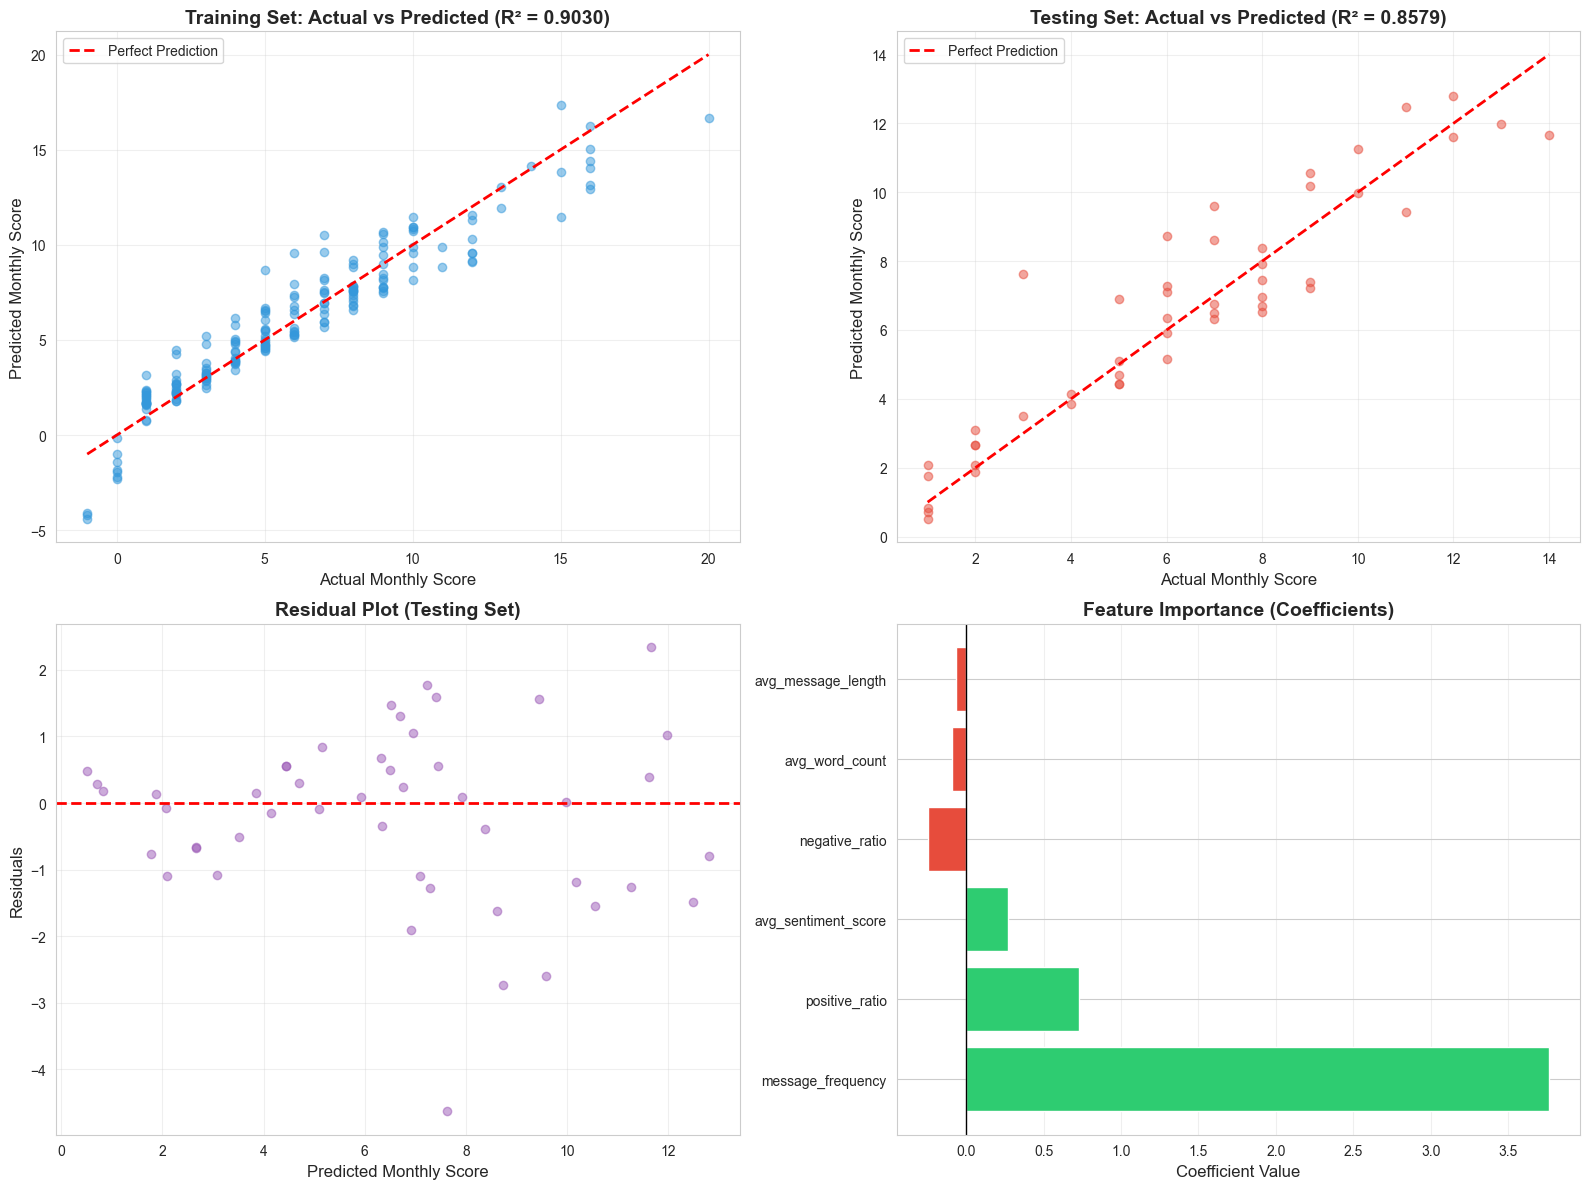

In [34]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted (Training)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5, color='#3498db')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Monthly Score', fontsize=12)
axes[0, 0].set_ylabel('Predicted Monthly Score', fontsize=12)
axes[0, 0].set_title(f'Training Set: Actual vs Predicted (R² = {train_r2:.4f})', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Testing)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, color='#e74c3c')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Monthly Score', fontsize=12)
axes[0, 1].set_ylabel('Predicted Monthly Score', fontsize=12)
axes[0, 1].set_title(f'Testing Set: Actual vs Predicted (R² = {test_r2:.4f})', 
                     fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals (Testing)
residuals = y_test - y_test_pred
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.5, color='#9b59b6')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Monthly Score', fontsize=12)
axes[1, 0].set_ylabel('Residuals', fontsize=12)
axes[1, 0].set_title('Residual Plot (Testing Set)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance
importance_df = coef_df.copy()
colors_list = ['#2ecc71' if x > 0 else '#e74c3c' for x in importance_df['Coefficient']]
axes[1, 1].barh(importance_df['Feature'], importance_df['Coefficient'], color=colors_list)
axes[1, 1].set_xlabel('Coefficient Value', fontsize=12)
axes[1, 1].set_title('Feature Importance (Coefficients)', fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('visualizations/09_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()


FEATURE CORRELATION ANALYSIS


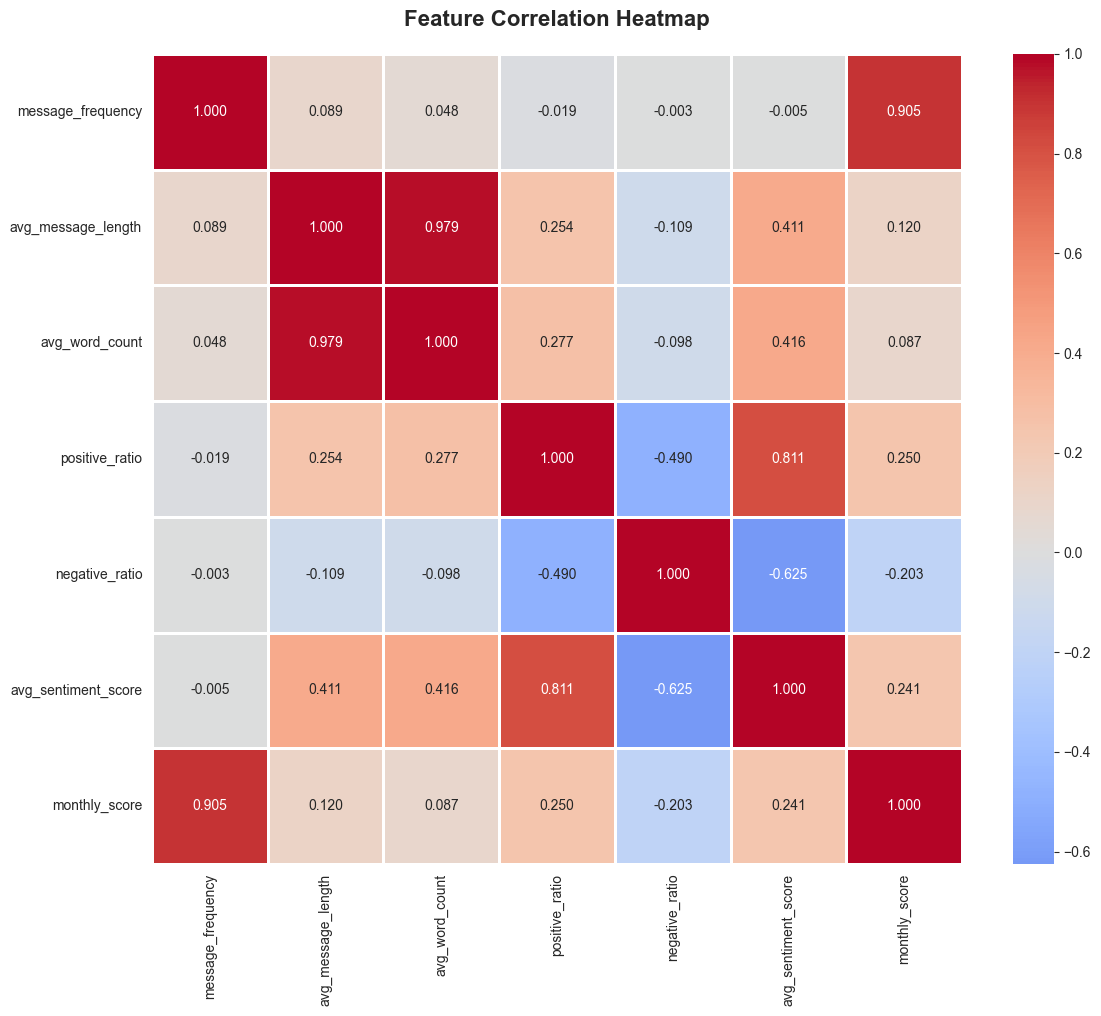


Correlations with Monthly Score:
message_frequency      0.904624
positive_ratio         0.249831
avg_sentiment_score    0.241089
avg_message_length     0.120011
avg_word_count         0.087150
negative_ratio        -0.202980
Name: monthly_score, dtype: float64


In [35]:
# Feature correlation analysis
print("\n" + "=" * 80)
print("FEATURE CORRELATION ANALYSIS")
print("=" * 80)

# Add target to feature dataset for correlation
correlation_data = X.copy()
correlation_data['monthly_score'] = y

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Visualize correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('visualizations/10_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Show correlations with target
print("\nCorrelations with Monthly Score:")
target_correlations = correlation_matrix['monthly_score'].drop('monthly_score').sort_values(ascending=False)
print(target_correlations)

**Model Findings:**

1. **Feature Importance:** The coefficients reveal which features most strongly influence monthly sentiment scores
2. **Model Performance:** The R² score indicates the model's explanatory power
3. **Correlations:** The correlation analysis shows relationships between features and the target variable
4. **Predictions:** The model can be used to predict sentiment scores based on employee behavior patterns

**Key Insights:**
- Positive and negative ratios are strong predictors of monthly scores
- Average sentiment score correlates with overall monthly performance
- Message frequency and length provide additional context for sentiment analysis

---
# Summary and Conclusions

## Project Summary

This comprehensive analysis of employee sentiment has been completed with the following outcomes:

In [36]:
# Generate final summary statistics
print("=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)

print(f"\n1. DATASET")
print(f"   - Total messages analyzed: {len(df):,}")
print(f"   - Unique employees: {df['employee'].nunique():,}")
print(f"   - Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

print(f"\n2. SENTIMENT DISTRIBUTION")
for sentiment, count in df['sentiment'].value_counts().items():
    pct = (count / len(df)) * 100
    print(f"   - {sentiment}: {count:,} ({pct:.2f}%)")

print(f"\n3. TOP 3 POSITIVE EMPLOYEES (Latest Month: {sample_month})")
for idx, row in month_top_pos.iterrows():
    print(f"   {row['rank']}. {row['employee']}: Score = {row['monthly_score']}")

print(f"\n4. TOP 3 NEGATIVE EMPLOYEES (Latest Month: {sample_month})")
for idx, row in month_top_neg.iterrows():
    print(f"   {row['rank']}. {row['employee']}: Score = {row['monthly_score']}")

print(f"\n5. FLIGHT RISK EMPLOYEES")
print(f"   - Total identified: {len(flight_risk_df):,}")
print(f"   - Criteria: 4+ negative messages in any 30-day period")

print(f"\n6. PREDICTIVE MODEL")
print(f"   - Model type: Linear Regression")
print(f"   - R² Score (Test): {test_r2:.4f}")
print(f"   - RMSE (Test): {test_rmse:.4f}")
print(f"   - MAE (Test): {test_mae:.4f}")

print(f"\n7. DELIVERABLES")
print(f"   - Labeled dataset with sentiment")
print(f"   - {len(os.listdir('visualizations'))} visualizations generated")
print(f"   - Employee rankings (positive & negative)")
print(f"   - Flight risk employee list")
print(f"   - Predictive model with {test_r2*100:.2f}% variance explained")

print("\n" + "=" * 80)

PROJECT SUMMARY

1. DATASET
   - Total messages analyzed: 2,191
   - Unique employees: 10
   - Date range: 2010-01-01 to 2011-12-31

2. SENTIMENT DISTRIBUTION
   - Positive: 1,574 (71.84%)
   - Neutral: 454 (20.72%)
   - Negative: 163 (7.44%)

3. TOP 3 POSITIVE EMPLOYEES (Latest Month: 2011-12)
   1. Eric Bass: Score = 12
   2. Patti Thompson: Score = 12
   3. Lydia Delgado: Score = 10

4. TOP 3 NEGATIVE EMPLOYEES (Latest Month: 2011-12)
   1. Johnny Palmer: Score = 1
   2. Bobette Riner: Score = 3
   3. John Arnold: Score = 4

5. FLIGHT RISK EMPLOYEES
   - Total identified: 5
   - Criteria: 4+ negative messages in any 30-day period

6. PREDICTIVE MODEL
   - Model type: Linear Regression
   - R² Score (Test): 0.8579
   - RMSE (Test): 1.2922
   - MAE (Test): 0.9619

7. DELIVERABLES
   - Labeled dataset with sentiment
   - 10 visualizations generated
   - Employee rankings (positive & negative)
   - Flight risk employee list
   - Predictive model with 85.79% variance explained



In [37]:
# Save the complete labeled dataset
df.to_csv('labeled_dataset.csv', index=False)
print("\nLabeled dataset saved to: labeled_dataset.csv")

# Save model performance metrics
model_metrics = pd.DataFrame({
    'Metric': ['R² Score', 'RMSE', 'MAE'],
    'Training': [train_r2, train_rmse, train_mae],
    'Testing': [test_r2, test_rmse, test_mae]
})
model_metrics.to_csv('model_performance.csv', index=False)
print("Model performance metrics saved to: model_performance.csv")

# Save feature importance
coef_df.to_csv('feature_importance.csv', index=False)
print("Feature importance saved to: feature_importance.csv")

print("\nAll analyses completed successfully!")


Labeled dataset saved to: labeled_dataset.csv
Model performance metrics saved to: model_performance.csv
Feature importance saved to: feature_importance.csv

All analyses completed successfully!


---
## Key Recommendations

1. **Immediate Attention Required:** Flight risk employees should be contacted for engagement assessment
2. **Recognition:** Top positive employees should be recognized for their positive contribution
3. **Support:** Employees with consistently negative sentiment may need additional support or resources
4. **Monitoring:** Continue tracking sentiment trends to identify early warning signs
5. **Intervention:** Develop targeted interventions based on predictive model insights

---

**End of Analysis**